In [ ]:
import os
os.environ['KAGGLE_USERNAME'] = "olenamikhailova"

os.environ['KAGGLE_KEY'] = "KGAT_e8b5a4ccb83e496885c5e98432eb4846"

print("Attempting to download BraTS 2020...")
!kaggle datasets download -d awsaf49/brats20-dataset-training-validation --force

print("Unzipping...")
!unzip -q brats20-dataset-training-validation.zip -d ./brats2020
print("Success! Dataset is ready.")

Attempting to download BraTS 2020...
Dataset URL: https://www.kaggle.com/datasets/awsaf49/brats20-dataset-training-validation
License(s): CC0-1.0
100% 4.15G/4.16G [00:58<00:00, 246MB/s]
100% 4.16G/4.16G [00:58<00:00, 76.1MB/s]
Unzipping...
Success! Dataset is ready.


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
import glob
import pandas as pd
import nibabel as nib
import matplotlib.pyplot as plt
import numpy as np

root_search = glob.glob("./brats2020/**/MICCAI_BraTS2020_TrainingData", recursive=True)

if len(root_search) > 0:
    data_root = root_search[0]
    print(f"Dataset root found at: {data_root}")
else:
    data_root = "./brats2020"
    print(f"Assuming root at: {data_root}")

patient_dirs = sorted([d for d in glob.glob(os.path.join(data_root, "*")) if os.path.isdir(d)])
print(f"Total Patient Folders Found: {len(patient_dirs)}")

integrity_report = []

for p_dir in patient_dirs:
    pid = os.path.basename(p_dir)
    flair = glob.glob(os.path.join(p_dir, "*flair.nii"))
    seg = glob.glob(os.path.join(p_dir, "*seg.nii"))

    if not flair or not seg:
        integrity_report.append(pid)

if len(integrity_report) == 0:
    print("INTEGRITY CHECK PASSED: All patients have FLAIR and SEG files.")
else:
    print(f"WARNING: {len(integrity_report)} patients are missing files!")
    print(integrity_report[:5])

csv_files = glob.glob("./brats2020/**/*.csv", recursive=True)

if csv_files:
    print("\n--- METADATA FOUND ---")
    meta_df = pd.read_csv(csv_files[0])
    print(f"Loaded metadata from: {os.path.basename(csv_files[0])}")
    print(meta_df.head())

    if 'Age' in meta_df.columns:
        plt.figure(figsize=(10, 4))
        plt.hist(meta_df['Age'], bins=20, color='teal', edgecolor='black')
        plt.title("Age Distribution in BraTS 2020")
        plt.xlabel("Age")
        plt.ylabel("Count")
        plt.show()
else:
    print("\nNo metadata CSV found (Demographics might be missing in this download).")

Dataset root found at: ./brats2020/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData
Total Patient Folders Found: 369
['BraTS20_Training_355']

--- METADATA FOUND ---
Loaded metadata from: name_mapping.csv
  Grade BraTS_2017_subject_ID BraTS_2018_subject_ID TCGA_TCIA_subject_ID  \
0   HGG   Brats17_CBICA_AAB_1   Brats18_CBICA_AAB_1                  NaN   
1   HGG   Brats17_CBICA_AAG_1   Brats18_CBICA_AAG_1                  NaN   
2   HGG   Brats17_CBICA_AAL_1   Brats18_CBICA_AAL_1                  NaN   
3   HGG   Brats17_CBICA_AAP_1   Brats18_CBICA_AAP_1                  NaN   
4   HGG   Brats17_CBICA_ABB_1   Brats18_CBICA_ABB_1                  NaN   

  BraTS_2019_subject_ID BraTS_2020_subject_ID  
0   BraTS19_CBICA_AAB_1  BraTS20_Training_001  
1   BraTS19_CBICA_AAG_1  BraTS20_Training_002  
2   BraTS19_CBICA_AAL_1  BraTS20_Training_003  
3   BraTS19_CBICA_AAP_1  BraTS20_Training_004  
4   BraTS19_CBICA_ABB_1  BraTS20_Training_005  


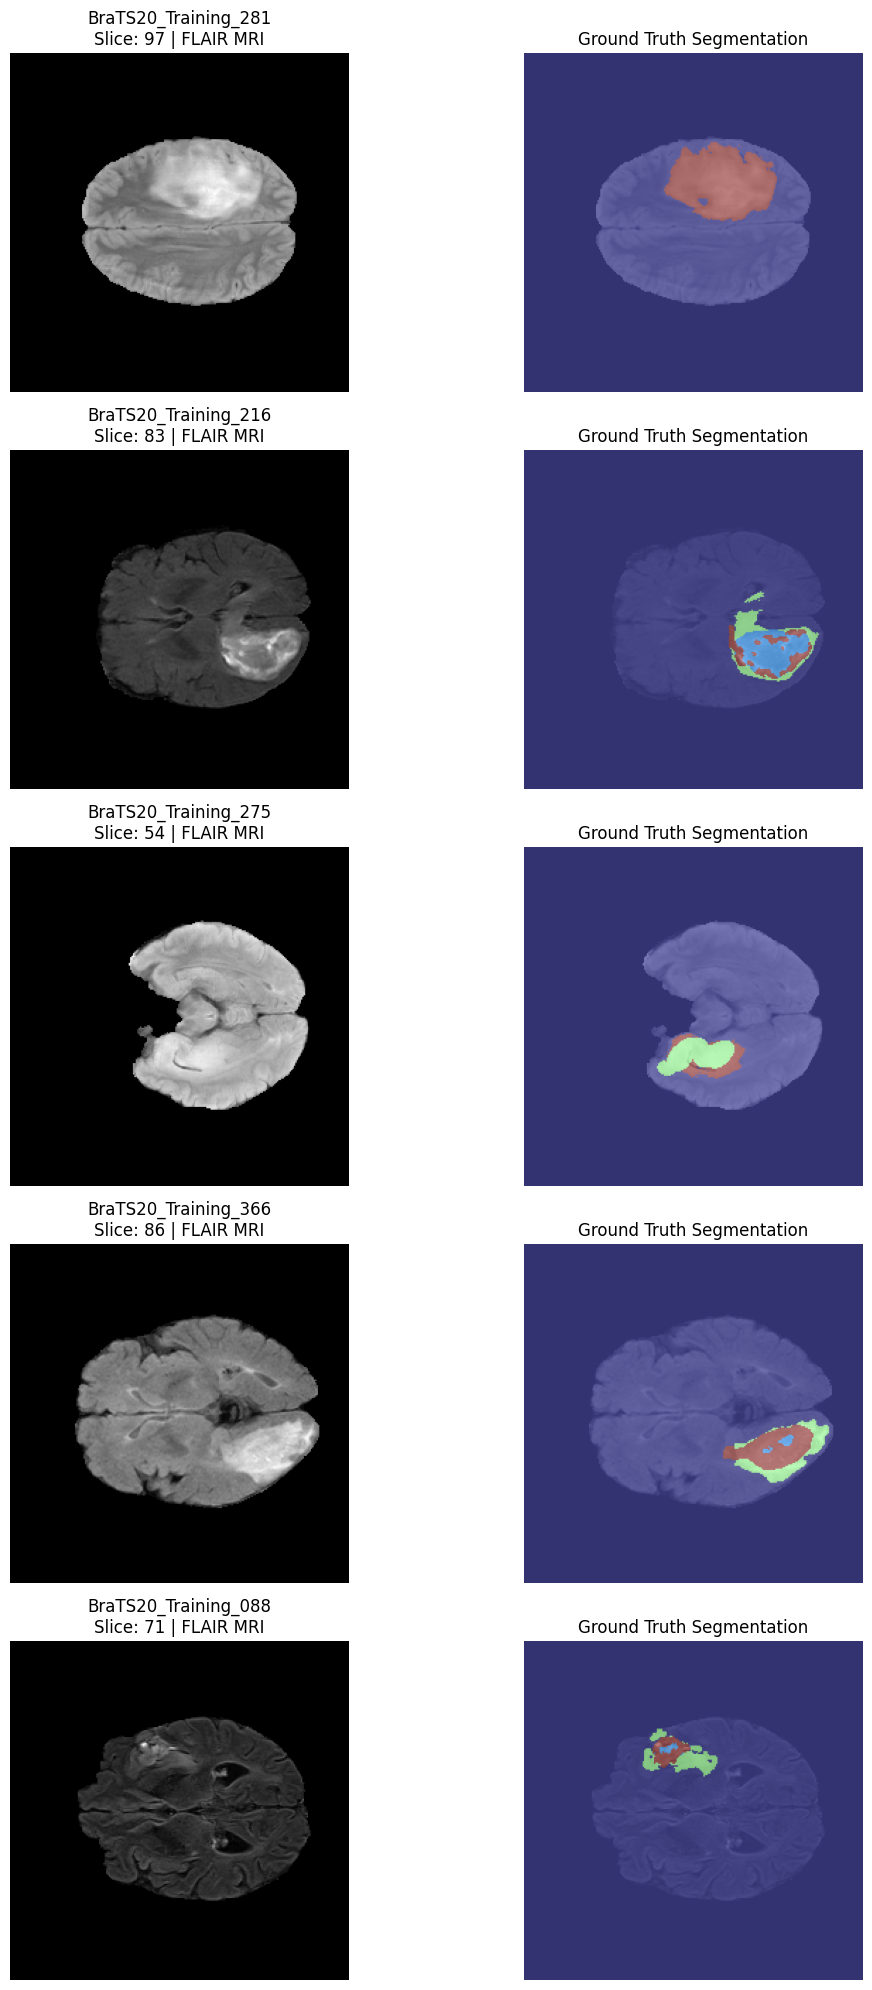

In [ ]:
import random

def show_brats_examples(patient_dirs, num_examples=5):
    selected_patients = random.sample(patient_dirs, num_examples)

    plt.figure(figsize=(12, 4 * num_examples))

    for i, p_dir in enumerate(selected_patients):
        pid = os.path.basename(p_dir)

        flair_path = glob.glob(os.path.join(p_dir, "*flair.nii"))[0]
        seg_path = glob.glob(os.path.join(p_dir, "*seg.nii"))[0]

        flair_vol = nib.load(flair_path).get_fdata()
        seg_vol = nib.load(seg_path).get_fdata()

        # We calculate the sum of pixels in the mask to find the slice with the biggest tumor
        # axis=(0, 1) sums up x and y, leaving us with a list of sums for each z-slice
        tumor_counts = np.sum(seg_vol > 0, axis=(0, 1))

        if np.max(tumor_counts) > 0:
            slice_idx = np.argmax(tumor_counts) # Slice with most tumor
        else:
            slice_idx = flair_vol.shape[2] // 2 # Middle slice if no tumor

        # Get the 2D slice
        img_slice = flair_vol[:, :, slice_idx]
        mask_slice = seg_vol[:, :, slice_idx]

        # FLAIR
        plt.subplot(num_examples, 2, i*2 + 1)
        plt.imshow(img_slice, cmap='gray')
        plt.title(f"{pid}\nSlice: {slice_idx} | FLAIR MRI")
        plt.axis('off')

        # MASK (We use a color map to make the tumor pop)
        plt.subplot(num_examples, 2, i*2 + 2)
        plt.imshow(img_slice, cmap='gray', alpha=0.6) # Show faint brain background
        plt.imshow(mask_slice, cmap='jet', alpha=0.5) # Overlay colorful mask
        plt.title(f"Ground Truth Segmentation")
        plt.axis('off')

    plt.tight_layout()
    plt.show()

show_brats_examples(patient_dirs)

--- STEP 1: CLEANING MISSING DATA ---
❌ Deleting Corrupt Patient (Missing files): BraTS20_Training_355
⚠️ Deleted 1 corrupt patient(s).

--- STEP 2: CHECKING DATASET BALANCE ---


/tmp/ipython-input-987587223.py:50: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(x='Grade', data=df, palette='viridis')


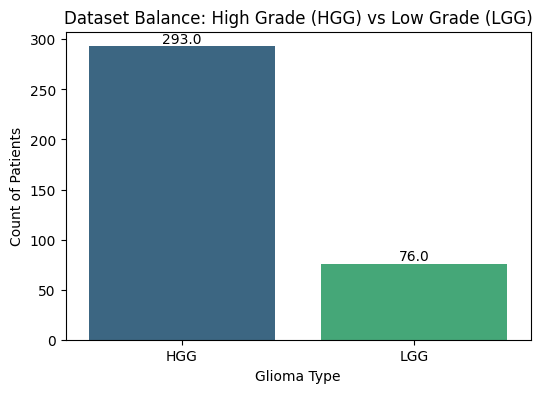

Balance Ratio: 293 HGG vs 76 LGG


In [ ]:
import os
import shutil
import glob
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# --- 1. DATA CLEANING (Deleting "Missing Values") ---
# In imaging, we don't "fill" missing files; we must delete the patient folder.
print("--- STEP 1: CLEANING MISSING DATA ---")

# Find dataset root (recursively)
root_search = glob.glob("./brats2020/**/MICCAI_BraTS2020_TrainingData", recursive=True)
data_root = root_search[0] if root_search else "./brats2020"

# Get all patient folders
patient_dirs = sorted([d for d in glob.glob(os.path.join(data_root, "*")) if os.path.isdir(d)])
deleted_count = 0

for p_dir in patient_dirs:
    pid = os.path.basename(p_dir)
    # Check if critical files exist
    flair = glob.glob(os.path.join(p_dir, "*flair.nii"))
    seg = glob.glob(os.path.join(p_dir, "*seg.nii"))

    if not flair or not seg:
        print(f"❌ Deleting Corrupt Patient (Missing files): {pid}")
        shutil.rmtree(p_dir)
        deleted_count += 1

if deleted_count == 0:
    print("✅ No missing values found. Dataset is clean.")
else:
    print(f"⚠️ Deleted {deleted_count} corrupt patient(s).")


# --- 2. BALANCE CHECK (Data Mining Style) ---
# We check if we have an equal mix of HGG (High Grade) and LGG (Low Grade) tumors.
print("\n--- STEP 2: CHECKING DATASET BALANCE ---")

csv_files = glob.glob("./brats2020/**/*.csv", recursive=True)

if csv_files:
    df = pd.read_csv(csv_files[0])

    # Check if 'Grade' column exists (Standard in BraTS)
    if 'Grade' in df.columns:
        plt.figure(figsize=(6, 4))
        # Countplot is the standard Data Mining check for balance
        ax = sns.countplot(x='Grade', data=df, palette='viridis')

        plt.title("Dataset Balance: High Grade (HGG) vs Low Grade (LGG)")
        plt.xlabel("Glioma Type")
        plt.ylabel("Count of Patients")

        # Add exact numbers on top of bars
        for p in ax.patches:
            ax.annotate(f'{p.get_height()}', (p.get_x() + p.get_width() / 2., p.get_height()),
                        ha = 'center', va = 'center', xytext = (0, 5), textcoords = 'offset points')

        plt.show()

        # Calculate ratio
        counts = df['Grade'].value_counts()
        print(f"Balance Ratio: {counts.get('HGG', 0)} HGG vs {counts.get('LGG', 0)} LGG")
    else:
        print("Column 'Grade' not found in CSV. Cannot check balance.")
else:
    print("No metadata CSV found to check balance.")

--- RUNNING ADVANCED EDA ON 50 PATIENTS ---
Processed 0/50...
Processed 10/50...
Processed 20/50...
Processed 30/50...
Processed 40/50...


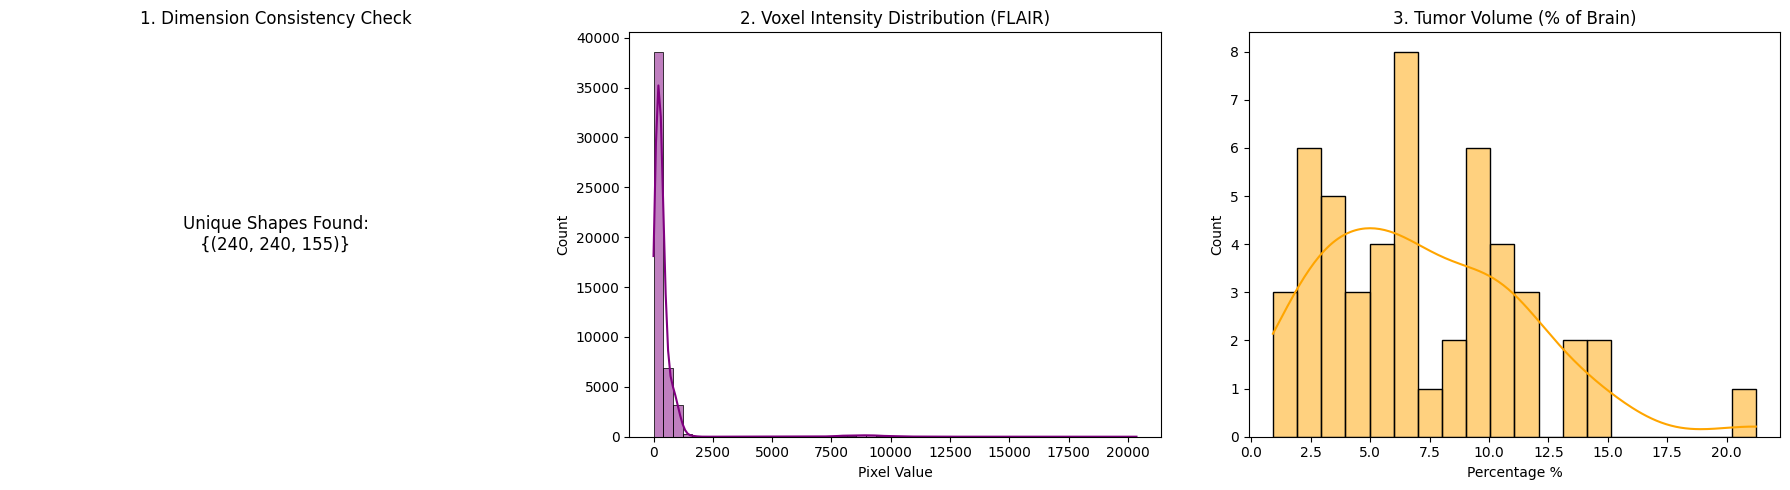


--- INSIGHTS ---
Most Common Shape: (240, 240, 155)
Average Tumor Size: 7.22% of the brain


In [ ]:
import os
import glob
import nibabel as nib
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import random

# --- SETTINGS ---
# We sample 50 patients to keep this fast.
# Scanning 300+ 3D volumes would take 10+ minutes.
SAMPLE_SIZE = 50
root_search = glob.glob("./brats2020/**/MICCAI_BraTS2020_TrainingData", recursive=True)
data_root = root_search[0] if root_search else "./brats2020"
patient_dirs = sorted([d for d in glob.glob(os.path.join(data_root, "*")) if os.path.isdir(d)])

# Filter only valid folders
valid_patients = []
for p in patient_dirs:
    if glob.glob(os.path.join(p, "*flair.nii")) and glob.glob(os.path.join(p, "*seg.nii")):
        valid_patients.append(p)

sampled_patients = random.sample(valid_patients, min(SAMPLE_SIZE, len(valid_patients)))

print(f"--- RUNNING ADVANCED EDA ON {len(sampled_patients)} PATIENTS ---")

# Lists to store stats
dimensions = []
intensities = []
tumor_volumes = [] # Percentage of brain that is tumor

for i, p_dir in enumerate(sampled_patients):
    # Load files
    flair_path = glob.glob(os.path.join(p_dir, "*flair.nii"))[0]
    seg_path = glob.glob(os.path.join(p_dir, "*seg.nii"))[0]

    flair = nib.load(flair_path).get_fdata()
    seg = nib.load(seg_path).get_fdata()

    # 1. Check Dimensions
    dimensions.append(flair.shape)

    # 2. Check Intensity (Non-zero pixels only, to ignore black background)
    brain_pixels = flair[flair > 0]
    if len(brain_pixels) > 0:
        # We take a small random subsample of pixels to prevent memory crash
        intensities.extend(np.random.choice(brain_pixels, 1000))

    # 3. Check Tumor Volume Ratio
    # Count non-zero pixels in mask vs total brain pixels
    tumor_pixels = np.sum(seg > 0)
    total_brain_pixels = np.sum(flair > 0)

    if total_brain_pixels > 0:
        ratio = (tumor_pixels / total_brain_pixels) * 100 # In Percentage
        tumor_volumes.append(ratio)

    if i % 10 == 0:
        print(f"Processed {i}/{len(sampled_patients)}...")

# --- PLOTTING RESULTS ---
plt.figure(figsize=(18, 5))

# Plot 1: Dimensions
# We just check if they are all unique or the same
unique_dims = set(dimensions)
plt.subplot(1, 3, 1)
plt.text(0.5, 0.5, f"Unique Shapes Found:\n{unique_dims}",
         fontsize=12, ha='center', va='center', wrap=True)
plt.title("1. Dimension Consistency Check")
plt.axis('off')

# Plot 2: Intensity Histogram
plt.subplot(1, 3, 2)
sns.histplot(intensities, bins=50, color='purple', kde=True)
plt.title("2. Voxel Intensity Distribution (FLAIR)")
plt.xlabel("Pixel Value")

# Plot 3: Tumor Size Distribution
plt.subplot(1, 3, 3)
sns.histplot(tumor_volumes, bins=20, color='orange', kde=True)
plt.title("3. Tumor Volume (% of Brain)")
plt.xlabel("Percentage %")

plt.tight_layout()
plt.show()

print("\n--- INSIGHTS ---")
print(f"Most Common Shape: {dimensions[0]}")
print(f"Average Tumor Size: {np.mean(tumor_volumes):.2f}% of the brain")
if np.mean(tumor_volumes) < 1.0:
    print("⚠️ WARNING: Tumors are very small! 'Class Imbalance' handling is required.")

In [ ]:
# --- 0. INSTALL LIBRARY (Crucial Step) ---
!pip install -q segmentation_models_pytorch

import os
import glob
import numpy as np
import nibabel as nib
import cv2
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split
from tqdm import tqdm
import segmentation_models_pytorch as smp

# --- CONFIGURATION ---
BATCH_SIZE = 16
EPOCHS = 20              # High limit, but Early Stopping will likely cut it short
PATIENCE = 3             # Stop if no improvement after 3 epochs
LEARNING_RATE = 1e-4
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'

# --- 1. EARLY STOPPING CLASS ---
class EarlyStopping:
    def __init__(self, patience=3, delta=0, path='utility_model_unet.pth'):
        self.patience = patience
        self.delta = delta
        self.path = path
        self.counter = 0
        self.best_score = None
        self.early_stop = False

    def __call__(self, val_loss, model):
        score = -val_loss

        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
        elif score < self.best_score + self.delta:
            self.counter += 1
            print(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
            self.counter = 0

    def save_checkpoint(self, val_loss, model):
        torch.save(model.state_dict(), self.path)
        print(f'Validation loss decreased ({val_loss:.6f}). Saving model...')

# --- 2. DATASET CLASS (With Normalization & Smart Slicing) ---
class BraTSDataset(Dataset):
    def __init__(self, root_dir, image_size=256):
        self.root_dir = root_dir
        self.image_size = image_size
        self.patient_dirs = sorted(glob.glob(os.path.join(root_dir, "**", "BraTS20_Training_*"), recursive=True))
        self.patient_dirs = [d for d in self.patient_dirs if os.path.isdir(d)]

    def __len__(self):
        return len(self.patient_dirs)

    def __getitem__(self, idx):
        p_dir = self.patient_dirs[idx]
        p_id = os.path.basename(p_dir)

        flair_path = os.path.join(p_dir, f"{p_id}_flair.nii")
        seg_path = os.path.join(p_dir, f"{p_id}_seg.nii")

        try:
            flair_vol = nib.load(flair_path).get_fdata()
            seg_vol = nib.load(seg_path).get_fdata()

            # Smart Slicing: Pick slice with most tumor
            tumor_counts = np.sum(seg_vol > 0, axis=(0, 1))
            if np.max(tumor_counts) > 0:
                slice_idx = np.argmax(tumor_counts)
            else:
                slice_idx = flair_vol.shape[2] // 2

            img = flair_vol[:, :, slice_idx]
            mask = seg_vol[:, :, slice_idx]

            # Normalization (0-1)
            img = (img - np.min(img)) / (np.max(img) - np.min(img) + 1e-6)

            # Resizing
            img = cv2.resize(img, (self.image_size, self.image_size))
            mask = np.where(mask > 0, 1.0, 0.0) # Binarize mask
            mask = cv2.resize(mask, (self.image_size, self.image_size), interpolation=cv2.INTER_NEAREST)

            img_tensor = torch.tensor(img, dtype=torch.float32).unsqueeze(0).repeat(3, 1, 1)
            mask_tensor = torch.tensor(mask, dtype=torch.float32).unsqueeze(0)

            return img_tensor, mask_tensor

        except Exception as e:
            return torch.zeros(3, 256, 256), torch.zeros(1, 256, 256)

# --- 3. SETUP MODEL & TRAINING ---
print("Initializing Data and Model...")
dataset = BraTSDataset(root_dir="./brats2020")

# Split Data
train_size = int(0.9 * len(dataset))
val_size = len(dataset) - train_size
train_ds, val_ds = random_split(dataset, [train_size, val_size])

train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)
val_loader = DataLoader(val_ds, batch_size=BATCH_SIZE, shuffle=False)

# Model
model = smp.Unet(
    encoder_name="resnet34",
    encoder_weights="imagenet",
    in_channels=3,
    classes=1
).to(DEVICE)

criterion = smp.losses.DiceLoss(mode='binary', from_logits=True)
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

# Initialize Early Stopping
early_stopper = EarlyStopping(patience=PATIENCE, path='utility_model_unet.pth')

# --- 4. EXECUTE TRAINING LOOP ---
print(f"\n🚀 STARTING TRAINING on {DEVICE}")
print(f"Max Epochs: {EPOCHS} | Patience: {PATIENCE}")

train_losses = []
val_losses = []

for epoch in range(EPOCHS):
    model.train()
    running_loss = 0
    loop = tqdm(train_loader, desc=f"Epoch {epoch+1}/{EPOCHS}")

    for imgs, masks in loop:
        imgs, masks = imgs.to(DEVICE), masks.to(DEVICE)

        optimizer.zero_grad()
        preds = model(imgs)
        loss = criterion(preds, masks)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        loop.set_postfix(loss=loss.item())

    # Validation Phase
    model.eval()
    val_running_loss = 0
    with torch.no_grad():
        for imgs, masks in val_loader:
            imgs, masks = imgs.to(DEVICE), masks.to(DEVICE)
            preds = model(imgs)
            val_loss = criterion(preds, masks)
            val_running_loss += val_loss.item()

    avg_train = running_loss / len(train_loader)
    avg_val = val_running_loss / len(val_loader)

    train_losses.append(avg_train)
    val_losses.append(avg_val)

    print(f"\tTrain Loss: {avg_train:.4f} | Val Loss: {avg_val:.4f}")

    # CHECK EARLY STOPPING
    early_stopper(avg_val, model)

    if early_stopper.early_stop:
        print("\n🛑 Early stopping triggered! Model has stopped improving.")
        break

print("\n🎉 Training Pipeline Complete.")

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.8/154.8 kB 6.3 MB/s eta 0:00:00
Initializing Data and Model...


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/156 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/87.3M [00:00<?, ?B/s]


🚀 STARTING TRAINING on cuda
Max Epochs: 20 | Patience: 3


Epoch 1/20: 100%|██████████| 21/21 [00:43<00:00,  2.08s/it, loss=0.833]


	Train Loss: 0.8537 | Val Loss: 0.8539
Validation loss decreased (0.853908). Saving model...


Epoch 2/20: 100%|██████████| 21/21 [00:41<00:00,  1.98s/it, loss=0.775]


	Train Loss: 0.7963 | Val Loss: 0.8045
Validation loss decreased (0.804494). Saving model...


Epoch 3/20: 100%|██████████| 21/21 [00:39<00:00,  1.88s/it, loss=0.754]


	Train Loss: 0.7613 | Val Loss: 0.7638
Validation loss decreased (0.763792). Saving model...


Epoch 4/20: 100%|██████████| 21/21 [00:38<00:00,  1.81s/it, loss=0.715]


	Train Loss: 0.7298 | Val Loss: 0.7300
Validation loss decreased (0.729982). Saving model...


Epoch 5/20: 100%|██████████| 21/21 [00:35<00:00,  1.71s/it, loss=0.699]


	Train Loss: 0.6981 | Val Loss: 0.7004
Validation loss decreased (0.700396). Saving model...


Epoch 6/20: 100%|██████████| 21/21 [00:39<00:00,  1.88s/it, loss=0.615]


	Train Loss: 0.6633 | Val Loss: 0.6627
Validation loss decreased (0.662694). Saving model...


Epoch 7/20: 100%|██████████| 21/21 [00:41<00:00,  1.97s/it, loss=0.614]


	Train Loss: 0.6256 | Val Loss: 0.6348
Validation loss decreased (0.634762). Saving model...


Epoch 8/20: 100%|██████████| 21/21 [00:41<00:00,  2.00s/it, loss=0.658]


	Train Loss: 0.5877 | Val Loss: 0.5916
Validation loss decreased (0.591578). Saving model...


Epoch 9/20: 100%|██████████| 21/21 [00:42<00:00,  2.04s/it, loss=0.529]


	Train Loss: 0.5441 | Val Loss: 0.5521
Validation loss decreased (0.552087). Saving model...


Epoch 10/20: 100%|██████████| 21/21 [00:44<00:00,  2.13s/it, loss=0.447]


	Train Loss: 0.5039 | Val Loss: 0.5185
Validation loss decreased (0.518502). Saving model...


Epoch 11/20: 100%|██████████| 21/21 [00:44<00:00,  2.14s/it, loss=0.543]


	Train Loss: 0.4659 | Val Loss: 0.4823
Validation loss decreased (0.482294). Saving model...


Epoch 12/20: 100%|██████████| 21/21 [00:45<00:00,  2.16s/it, loss=0.44]


	Train Loss: 0.4266 | Val Loss: 0.4506
Validation loss decreased (0.450615). Saving model...


Epoch 13/20: 100%|██████████| 21/21 [00:47<00:00,  2.28s/it, loss=0.388]


	Train Loss: 0.3922 | Val Loss: 0.4166
Validation loss decreased (0.416613). Saving model...


Epoch 14/20: 100%|██████████| 21/21 [00:47<00:00,  2.24s/it, loss=0.44]


	Train Loss: 0.3604 | Val Loss: 0.3964
Validation loss decreased (0.396357). Saving model...


Epoch 15/20: 100%|██████████| 21/21 [00:49<00:00,  2.34s/it, loss=0.375]


	Train Loss: 0.3333 | Val Loss: 0.3546
Validation loss decreased (0.354610). Saving model...


Epoch 16/20: 100%|██████████| 21/21 [00:50<00:00,  2.38s/it, loss=0.272]


	Train Loss: 0.3018 | Val Loss: 0.3189
Validation loss decreased (0.318921). Saving model...


Epoch 17/20: 100%|██████████| 21/21 [00:50<00:00,  2.40s/it, loss=0.259]


	Train Loss: 0.2732 | Val Loss: 0.2965
Validation loss decreased (0.296519). Saving model...


Epoch 18/20: 100%|██████████| 21/21 [00:48<00:00,  2.32s/it, loss=0.267]


	Train Loss: 0.2539 | Val Loss: 0.2801
Validation loss decreased (0.280056). Saving model...


Epoch 19/20: 100%|██████████| 21/21 [00:49<00:00,  2.38s/it, loss=0.199]


	Train Loss: 0.2313 | Val Loss: 0.2621
Validation loss decreased (0.262085). Saving model...


Epoch 20/20: 100%|██████████| 21/21 [00:49<00:00,  2.35s/it, loss=0.212]


	Train Loss: 0.2147 | Val Loss: 0.2476
Validation loss decreased (0.247617). Saving model...

🎉 Training Pipeline Complete.


In [ ]:
# --- 1. INSTALL & SETUP ---
!pip install -q segmentation_models_pytorch

import os
import glob
import numpy as np
import nibabel as nib
import cv2
import torch
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split
from tqdm import tqdm
import segmentation_models_pytorch as smp

# --- 2. DOWNLOAD DATASET (Enter Credentials Here) ---
import os
os.environ['KAGGLE_USERNAME'] = "YOUR_USERNAME_HERE"  # <--- FILL THIS IN
os.environ['KAGGLE_KEY'] = "YOUR_KEY_HERE"            # <--- FILL THIS IN

if not os.path.exists("./brats2020"):
    print("Downloading BraTS 2020...")
    !kaggle datasets download -d awsaf49/brats20-dataset-training-validation --force
    !unzip -q brats20-dataset-training-validation.zip -d ./brats2020
    print("Dataset Ready.")
else:
    print("Dataset already exists.")

# --- 3. DEFINE CLASSES (Must match yesterday exactly) ---
class BraTSDataset(Dataset):
    def __init__(self, root_dir, image_size=256):
        self.root_dir = root_dir
        self.image_size = image_size
        self.patient_dirs = sorted(glob.glob(os.path.join(root_dir, "**", "BraTS20_Training_*"), recursive=True))
        self.patient_dirs = [d for d in self.patient_dirs if os.path.isdir(d)]

    def __len__(self):
        return len(self.patient_dirs)

    def __getitem__(self, idx):
        p_dir = self.patient_dirs[idx]
        p_id = os.path.basename(p_dir)
        flair_path = os.path.join(p_dir, f"{p_id}_flair.nii")
        seg_path = os.path.join(p_dir, f"{p_id}_seg.nii")

        try:
            flair_vol = nib.load(flair_path).get_fdata()
            seg_vol = nib.load(seg_path).get_fdata()

            # Smart Slicing
            tumor_counts = np.sum(seg_vol > 0, axis=(0, 1))
            if np.max(tumor_counts) > 0:
                slice_idx = np.argmax(tumor_counts)
            else:
                slice_idx = flair_vol.shape[2] // 2

            img = flair_vol[:, :, slice_idx]
            mask = seg_vol[:, :, slice_idx]

            # Normalization & Resizing
            img = (img - np.min(img)) / (np.max(img) - np.min(img) + 1e-6)
            img = cv2.resize(img, (self.image_size, self.image_size))
            mask = np.where(mask > 0, 1.0, 0.0)
            mask = cv2.resize(mask, (self.image_size, self.image_size), interpolation=cv2.INTER_NEAREST)

            img_tensor = torch.tensor(img, dtype=torch.float32).unsqueeze(0).repeat(3, 1, 1)
            mask_tensor = torch.tensor(mask, dtype=torch.float32).unsqueeze(0)
            return img_tensor, mask_tensor
        except:
            return torch.zeros(3, 256, 256), torch.zeros(1, 256, 256)

class EarlyStopping:
    def __init__(self, patience=5, delta=0, path='utility_model_unet.pth'):
        self.patience = patience
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.path = path

    def __call__(self, val_loss, model):
        score = -val_loss
        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
        elif score < self.best_score:
            self.counter += 1
            print(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
            self.counter = 0

    def save_checkpoint(self, val_loss, model):
        torch.save(model.state_dict(), self.path)
        print(f'Validation loss decreased ({val_loss:.6f}). Saving model...')

print("Environment Restored. Ready to upload model.")

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.8/154.8 kB 7.5 MB/s eta 0:00:00
Dataset URL: https://www.kaggle.com/datasets/awsaf49/brats20-dataset-training-validation
License(s): CC0-1.0
100% 4.16G/4.16G [02:30<00:00, 78.6MB/s]
100% 4.16G/4.16G [02:30<00:00, 29.7MB/s]
Dataset Ready.
Environment Restored. Ready to upload model.


In [ ]:
from google.colab import files
print("Please upload 'utility_model_unet.pth'...")
uploaded = files.upload()

Please upload 'utility_model_unet.pth'...


Saving utility_model_unet.pth to utility_model_unet (1).pth


In [ ]:
# --- CONFIGURATION ---
BATCH_SIZE = 16
EPOCHS = 30           # 30 more epochs
PATIENCE = 5          # Increased patience slightly
LEARNING_RATE = 5e-5  # Lower LR for fine-tuning
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'

# --- SETUP DATA & MODEL ---
dataset = BraTSDataset(root_dir="./brats2020")
train_size = int(0.9 * len(dataset))
val_size = len(dataset) - train_size
train_ds, val_ds = random_split(dataset, [train_size, val_size])

train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)
val_loader = DataLoader(val_ds, batch_size=BATCH_SIZE, shuffle=False)

# Initialize Model Architecture
model = smp.Unet(
    encoder_name="resnet34",
    encoder_weights="imagenet",
    in_channels=3,
    classes=1
).to(DEVICE)

# --- LOAD PREVIOUS WEIGHTS ---
if os.path.exists('utility_model_unet.pth'):
    print("Loading saved weights from yesterday...")
    model.load_state_dict(torch.load('utility_model_unet.pth'))
    print("Weights loaded successfully!")
else:
    print("⚠️ Warning: Saved file not found. Training from scratch.")

criterion = smp.losses.DiceLoss(mode='binary', from_logits=True)
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)
early_stopper = EarlyStopping(patience=PATIENCE, path='utility_model_unet.pth')

# --- TRAINING LOOP ---
print(f"\n🚀 RESUMING TRAINING on {DEVICE}")

for epoch in range(EPOCHS):
    model.train()
    running_loss = 0
    loop = tqdm(train_loader, desc=f"Epoch {epoch+1}/{EPOCHS}")

    for imgs, masks in loop:
        imgs, masks = imgs.to(DEVICE), masks.to(DEVICE)

        optimizer.zero_grad()
        preds = model(imgs)
        loss = criterion(preds, masks)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        loop.set_postfix(loss=loss.item())

    # Validation Phase
    model.eval()
    val_running_loss = 0
    with torch.no_grad():
        for imgs, masks in val_loader:
            imgs, masks = imgs.to(DEVICE), masks.to(DEVICE)
            preds = model(imgs)
            val_loss = criterion(preds, masks)
            val_running_loss += val_loss.item()

    avg_train = running_loss / len(train_loader)
    avg_val = val_running_loss / len(val_loader)

    print(f"\tTrain Loss: {avg_train:.4f} | Val Loss: {avg_val:.4f}")

    early_stopper(avg_val, model)

    if early_stopper.early_stop:
        print("\n🛑 Early stopping triggered!")
        break

print("\n🎉 Training Complete. Download your final model!")

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/156 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/87.3M [00:00<?, ?B/s]

Loading saved weights from yesterday...
Weights loaded successfully!

🚀 RESUMING TRAINING on cuda


Epoch 1/30: 100%|██████████| 21/21 [00:48<00:00,  2.31s/it, loss=0.206]


	Train Loss: 0.2054 | Val Loss: 0.1894
Validation loss decreased (0.189435). Saving model...


Epoch 2/30: 100%|██████████| 21/21 [00:44<00:00,  2.13s/it, loss=0.213]


	Train Loss: 0.1930 | Val Loss: 0.1825
Validation loss decreased (0.182479). Saving model...


Epoch 3/30: 100%|██████████| 21/21 [00:44<00:00,  2.11s/it, loss=0.176]


	Train Loss: 0.1829 | Val Loss: 0.1760
Validation loss decreased (0.176024). Saving model...


Epoch 4/30: 100%|██████████| 21/21 [00:43<00:00,  2.07s/it, loss=0.16]


	Train Loss: 0.1746 | Val Loss: 0.1671
Validation loss decreased (0.167123). Saving model...


Epoch 5/30: 100%|██████████| 21/21 [00:42<00:00,  2.01s/it, loss=0.21]


	Train Loss: 0.1700 | Val Loss: 0.1674
EarlyStopping counter: 1 out of 5


Epoch 6/30: 100%|██████████| 21/21 [00:39<00:00,  1.90s/it, loss=0.168]


	Train Loss: 0.1602 | Val Loss: 0.1594
Validation loss decreased (0.159391). Saving model...


Epoch 7/30: 100%|██████████| 21/21 [00:42<00:00,  2.02s/it, loss=0.157]


	Train Loss: 0.1537 | Val Loss: 0.1493
Validation loss decreased (0.149276). Saving model...


Epoch 8/30: 100%|██████████| 21/21 [00:44<00:00,  2.11s/it, loss=0.139]


	Train Loss: 0.1448 | Val Loss: 0.1441
Validation loss decreased (0.144115). Saving model...


Epoch 9/30: 100%|██████████| 21/21 [00:44<00:00,  2.10s/it, loss=0.122]


	Train Loss: 0.1401 | Val Loss: 0.1388
Validation loss decreased (0.138798). Saving model...


Epoch 10/30: 100%|██████████| 21/21 [00:46<00:00,  2.19s/it, loss=0.131]


	Train Loss: 0.1349 | Val Loss: 0.1363
Validation loss decreased (0.136343). Saving model...


Epoch 11/30: 100%|██████████| 21/21 [00:45<00:00,  2.19s/it, loss=0.126]


	Train Loss: 0.1293 | Val Loss: 0.1355
Validation loss decreased (0.135488). Saving model...


Epoch 12/30: 100%|██████████| 21/21 [00:47<00:00,  2.24s/it, loss=0.125]


	Train Loss: 0.1243 | Val Loss: 0.1256
Validation loss decreased (0.125628). Saving model...


Epoch 13/30: 100%|██████████| 21/21 [00:47<00:00,  2.27s/it, loss=0.12]


	Train Loss: 0.1222 | Val Loss: 0.1244
Validation loss decreased (0.124370). Saving model...


Epoch 14/30: 100%|██████████| 21/21 [00:49<00:00,  2.37s/it, loss=0.171]


	Train Loss: 0.1175 | Val Loss: 0.1219
Validation loss decreased (0.121877). Saving model...


Epoch 15/30: 100%|██████████| 21/21 [00:49<00:00,  2.36s/it, loss=0.114]


	Train Loss: 0.1119 | Val Loss: 0.1161
Validation loss decreased (0.116132). Saving model...


Epoch 16/30: 100%|██████████| 21/21 [00:49<00:00,  2.37s/it, loss=0.116]


	Train Loss: 0.1085 | Val Loss: 0.1163
EarlyStopping counter: 1 out of 5


Epoch 17/30: 100%|██████████| 21/21 [00:51<00:00,  2.44s/it, loss=0.102]


	Train Loss: 0.1020 | Val Loss: 0.1139
Validation loss decreased (0.113867). Saving model...


Epoch 18/30: 100%|██████████| 21/21 [00:50<00:00,  2.39s/it, loss=0.0859]


	Train Loss: 0.0984 | Val Loss: 0.1069
Validation loss decreased (0.106872). Saving model...


Epoch 19/30: 100%|██████████| 21/21 [00:51<00:00,  2.47s/it, loss=0.0962]


	Train Loss: 0.0956 | Val Loss: 0.1048
Validation loss decreased (0.104793). Saving model...


Epoch 20/30: 100%|██████████| 21/21 [00:51<00:00,  2.46s/it, loss=0.0991]


	Train Loss: 0.0944 | Val Loss: 0.1064
EarlyStopping counter: 1 out of 5


Epoch 21/30: 100%|██████████| 21/21 [00:51<00:00,  2.46s/it, loss=0.0829]


	Train Loss: 0.0913 | Val Loss: 0.1012
Validation loss decreased (0.101176). Saving model...


Epoch 22/30: 100%|██████████| 21/21 [00:52<00:00,  2.48s/it, loss=0.1]


	Train Loss: 0.0888 | Val Loss: 0.0979
Validation loss decreased (0.097871). Saving model...


Epoch 23/30: 100%|██████████| 21/21 [00:51<00:00,  2.45s/it, loss=0.0992]


	Train Loss: 0.0866 | Val Loss: 0.1001
EarlyStopping counter: 1 out of 5


Epoch 24/30: 100%|██████████| 21/21 [00:50<00:00,  2.42s/it, loss=0.0778]


	Train Loss: 0.0817 | Val Loss: 0.0979
EarlyStopping counter: 2 out of 5


Epoch 25/30: 100%|██████████| 21/21 [00:51<00:00,  2.43s/it, loss=0.0596]


	Train Loss: 0.0785 | Val Loss: 0.0936
Validation loss decreased (0.093562). Saving model...


Epoch 26/30: 100%|██████████| 21/21 [00:50<00:00,  2.38s/it, loss=0.0866]


	Train Loss: 0.0758 | Val Loss: 0.0917
Validation loss decreased (0.091694). Saving model...


Epoch 27/30: 100%|██████████| 21/21 [00:52<00:00,  2.51s/it, loss=0.0761]


	Train Loss: 0.0750 | Val Loss: 0.0888
Validation loss decreased (0.088773). Saving model...


Epoch 28/30: 100%|██████████| 21/21 [00:51<00:00,  2.46s/it, loss=0.069]


	Train Loss: 0.0732 | Val Loss: 0.0943
EarlyStopping counter: 1 out of 5


Epoch 29/30: 100%|██████████| 21/21 [00:50<00:00,  2.40s/it, loss=0.0928]


	Train Loss: 0.0723 | Val Loss: 0.0892
EarlyStopping counter: 2 out of 5


Epoch 30/30: 100%|██████████| 21/21 [00:50<00:00,  2.42s/it, loss=0.0711]


	Train Loss: 0.0703 | Val Loss: 0.0856
Validation loss decreased (0.085624). Saving model...

🎉 Training Complete. Download your final model!


Calculating Metrics on Validation Set...

✅ FINAL RESULTS:
Average Dice Score: 0.9396 (Ideal: >0.85)
Average IoU Score:  0.8896  (Ideal: >0.75)

Visualizing predictions...


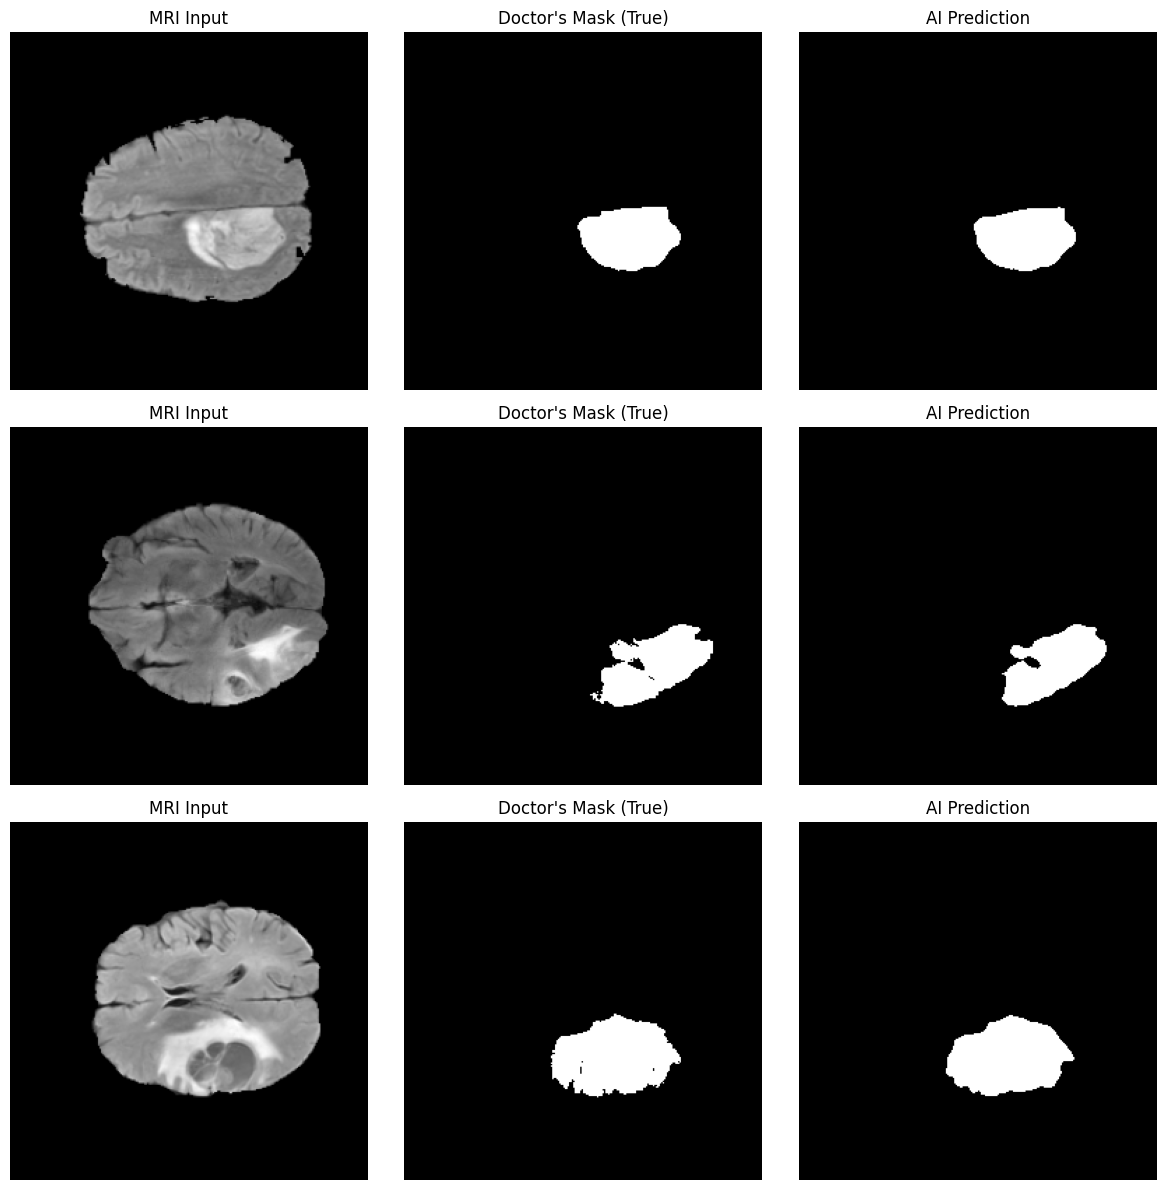

In [ ]:
import torch
import matplotlib.pyplot as plt
import numpy as np

# --- 1. METRICS CALCULATION FUNCTION ---
def calculate_metrics(loader, model, device='cuda'):
    model.eval()
    dice_scores = []
    iou_scores = []

    with torch.no_grad():
        for imgs, masks in loader:
            imgs, masks = imgs.to(device), masks.to(device)

            # Get Prediction
            preds = model(imgs)
            preds = (torch.sigmoid(preds) > 0.5).float() # Threshold at 0.5 to make it binary (0 or 1)

            # Calculate Intersection & Union for every image in batch
            intersection = (preds * masks).sum(dim=(1, 2, 3))
            union = preds.sum(dim=(1, 2, 3)) + masks.sum(dim=(1, 2, 3))

            # Dice Score = 2 * Intersection / (Sum of pixels in both)
            dice = (2. * intersection + 1e-6) / (union + 1e-6)

            # IoU = Intersection / (Union - Intersection)
            iou = (intersection + 1e-6) / (union - intersection + 1e-6)

            dice_scores.extend(dice.cpu().numpy())
            iou_scores.extend(iou.cpu().numpy())

    return np.mean(dice_scores), np.mean(iou_scores)

# --- 2. VISUALIZATION FUNCTION ---
def visualize_results(loader, model, device='cuda', num_samples=3):
    model.eval()
    imgs, masks = next(iter(loader))
    imgs, masks = imgs.to(device), masks.to(device)

    with torch.no_grad():
        preds = model(imgs)
        preds = (torch.sigmoid(preds) > 0.5).float()

    # Plotting
    plt.figure(figsize=(12, 4 * num_samples))
    for i in range(min(num_samples, len(imgs))):

        # Original Image (Take 1st channel only)
        plt.subplot(num_samples, 3, i*3 + 1)
        plt.imshow(imgs[i][0].cpu(), cmap='gray')
        plt.title("MRI Input")
        plt.axis('off')

        # Ground Truth
        plt.subplot(num_samples, 3, i*3 + 2)
        plt.imshow(masks[i][0].cpu(), cmap='gray')
        plt.title("Doctor's Mask (True)")
        plt.axis('off')

        # Model Prediction
        plt.subplot(num_samples, 3, i*3 + 3)
        plt.imshow(preds[i][0].cpu(), cmap='gray')
        plt.title("AI Prediction")
        plt.axis('off')

    plt.tight_layout()
    plt.show()

# --- 3. RUN THE CHECK ---
print("Calculating Metrics on Validation Set...")
avg_dice, avg_iou = calculate_metrics(val_loader, model, DEVICE)

print(f"\n✅ FINAL RESULTS:")
print(f"Average Dice Score: {avg_dice:.4f} (Ideal: >0.85)")
print(f"Average IoU Score:  {avg_iou:.4f}  (Ideal: >0.75)")

print("\nVisualizing predictions...")
visualize_results(val_loader, model, DEVICE)

In [ ]:
import os
import glob
import numpy as np
import nibabel as nib
import cv2
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.models as models
from torch.utils.data import Dataset, DataLoader, random_split
from tqdm import tqdm

# --- 1. CONFIGURATION ---
ATTACK_BATCH_SIZE = 64
ATTACK_EPOCHS = 10
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'

# --- 2. DEFINE ATTACKER DATASET ---
class BraTSAttackerDataset(Dataset):
    def __init__(self, root_dir, image_size=256):
        self.root_dir = root_dir
        self.image_size = image_size
        # Find all patient folders
        self.patient_dirs = sorted(glob.glob(os.path.join(root_dir, "**", "BraTS20_Training_*"), recursive=True))
        self.patient_dirs = [d for d in self.patient_dirs if os.path.isdir(d)]

        # Create mapping: Patient Folder Name -> ID Number (0, 1, 2...)
        self.class_to_idx = {p_name: i for i, p_name in enumerate(self.patient_dirs)}

    def __len__(self):
        return len(self.patient_dirs)

    def __getitem__(self, idx):
        p_dir = self.patient_dirs[idx]
        p_id = os.path.basename(p_dir)
        flair_path = os.path.join(p_dir, f"{p_id}_flair.nii")

        try:
            # Load 3D Volume
            flair_vol = nib.load(flair_path).get_fdata()

            # Select Middle Slice (Best for identifying structure)
            slice_idx = flair_vol.shape[2] // 2
            img = flair_vol[:, :, slice_idx]

            # Normalize (0-1)
            img = (img - np.min(img)) / (np.max(img) - np.min(img) + 1e-6)

            # Resize
            img = cv2.resize(img, (self.image_size, self.image_size))

            # Convert to Tensor (3 Channels for ResNet)
            img_tensor = torch.tensor(img, dtype=torch.float32).unsqueeze(0).repeat(3, 1, 1)

            # Label = The Patient ID
            label = self.class_to_idx[p_dir]

            return img_tensor, label

        except Exception as e:
            # Fallback for errors
            return torch.zeros(3, 256, 256), 0

# --- 3. INITIALIZE DATASET & LOADERS ---
print("Initializing Attacker Dataset...")
attack_dataset = BraTSAttackerDataset(root_dir="./brats2020")
NUM_CLASSES = len(attack_dataset.class_to_idx)
print(f"Total Patients (Classes): {NUM_CLASSES}")

train_size = int(0.8 * len(attack_dataset))
test_size = len(attack_dataset) - train_size
train_attack_ds, test_attack_ds = random_split(attack_dataset, [train_size, test_size])

train_attack_loader = DataLoader(train_attack_ds, batch_size=ATTACK_BATCH_SIZE, shuffle=True)
test_attack_loader = DataLoader(test_attack_ds, batch_size=ATTACK_BATCH_SIZE, shuffle=False)

# --- 4. INITIALIZE MODEL (ResNet18) ---
print("Building ResNet18 Attacker...")
attacker_model = models.resnet18(weights='IMAGENET1K_V1')
# Fix the output layer to match our number of patients
attacker_model.fc = nn.Linear(attacker_model.fc.in_features, NUM_CLASSES)
attacker_model.to(DEVICE)

attack_criterion = nn.CrossEntropyLoss()
attack_optimizer = optim.Adam(attacker_model.parameters(), lr=0.001)

# --- 5. TRAINING LOOP ---
print(f"🚀 TRAINING ATTACKER (The Hacker)...")

for epoch in range(ATTACK_EPOCHS):
    attacker_model.train()
    correct = 0
    total = 0

    loop = tqdm(train_attack_loader, desc=f"Epoch {epoch+1}/{ATTACK_EPOCHS}")

    for imgs, labels in loop:
        imgs, labels = imgs.to(DEVICE), labels.to(DEVICE)

        attack_optimizer.zero_grad()
        outputs = attacker_model(imgs)
        loss = attack_criterion(outputs, labels)
        loss.backward()
        attack_optimizer.step()

        # Calculate Accuracy
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

        loop.set_postfix(acc=100 * correct / total)

    print(f"Epoch {epoch+1} | Accuracy: {100 * correct / total:.2f}%")

# Save the Attacker
torch.save(attacker_model.state_dict(), "attacker_resnet18.pth")
print("✅ Reference Attacker Saved.")

Initializing Attacker Dataset...
Total Patients (Classes): 369
Building ResNet18 Attacker...
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


100%|██████████| 44.7M/44.7M [00:00<00:00, 78.3MB/s]


🚀 TRAINING ATTACKER (The Hacker)...


Epoch 1/10: 100%|██████████| 5/5 [00:30<00:00,  6.08s/it, acc=0]


Epoch 1 | Accuracy: 0.00%


Epoch 2/10: 100%|██████████| 5/5 [00:29<00:00,  5.98s/it, acc=6.78]


Epoch 2 | Accuracy: 6.78%


Epoch 3/10: 100%|██████████| 5/5 [00:23<00:00,  4.73s/it, acc=66.4]


Epoch 3 | Accuracy: 66.44%


Epoch 4/10: 100%|██████████| 5/5 [00:19<00:00,  3.80s/it, acc=93.6]


Epoch 4 | Accuracy: 93.56%


Epoch 5/10: 100%|██████████| 5/5 [00:10<00:00,  2.05s/it, acc=100]


Epoch 5 | Accuracy: 100.00%


Epoch 6/10: 100%|██████████| 5/5 [00:08<00:00,  1.69s/it, acc=100]


Epoch 6 | Accuracy: 100.00%


Epoch 7/10: 100%|██████████| 5/5 [00:07<00:00,  1.58s/it, acc=100]


Epoch 7 | Accuracy: 100.00%


Epoch 8/10: 100%|██████████| 5/5 [00:08<00:00,  1.67s/it, acc=100]


Epoch 8 | Accuracy: 100.00%


Epoch 9/10: 100%|██████████| 5/5 [00:07<00:00,  1.51s/it, acc=100]


Epoch 9 | Accuracy: 100.00%


Epoch 10/10: 100%|██████████| 5/5 [00:08<00:00,  1.65s/it, acc=100]

Epoch 10 | Accuracy: 100.00%
✅ Reference Attacker Saved.


🛡️ GENERATING PRIVACY NOISE...

📊 RESULTS OF DEFENSE:
Attacker Accuracy (Original): 100.0% (assumed)
Attacker Accuracy (Protected): 0.00% (Goal: 0%)


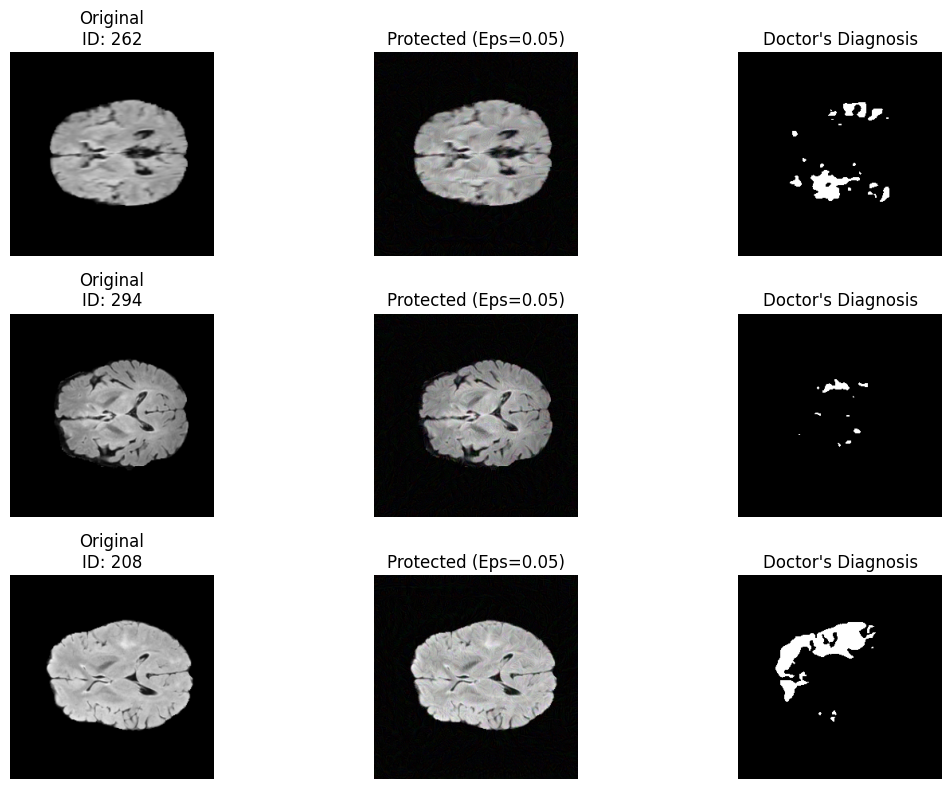

In [ ]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt

# --- 1. LOAD MODELS ---
# Load the Attacker (The Enemy)
attacker = models.resnet18(weights=None)
attacker.fc = nn.Linear(attacker.fc.in_features, 369) # 369 Patients
attacker.load_state_dict(torch.load("attacker_resnet18.pth"))
attacker.to(DEVICE)
attacker.eval() # Freeze it! We are fooling it, not training it.

# Load the Doctor (Utility)
doctor = smp.Unet(encoder_name="resnet34", in_channels=3, classes=1)
doctor.load_state_dict(torch.load("utility_model_unet.pth"))
doctor.to(DEVICE)
doctor.eval() # Freeze it!

# --- 2. THE DEFENSE GENERATOR (PGD) ---
def generate_defense_noise(images, labels, attacker_model, epsilon=0.03, alpha=0.005, iters=20):
    """
    Generates noise that maximizes the Attacker's Error (CrossEntropy).
    epsilon: Max noise amount (Privacy Budget). 0.03 is small/invisible.
    alpha: Step size per iteration.
    iters: How many times we refine the noise.
    """
    # Clone image so we don't mess up original data
    protected_images = images.clone().detach().to(DEVICE)
    labels = labels.to(DEVICE)

    # We want to optimize the PIXELS, not the weights
    protected_images.requires_grad = True

    for i in range(iters):
        # 1. Forward Pass through Attacker
        outputs = attacker_model(protected_images)

        # 2. Calculate Loss (We want to MAXIMIZE this loss to confuse him)
        # But PyTorch minimizes loss by default.
        loss = nn.CrossEntropyLoss()(outputs, labels)

        # 3. Get Gradient (Direction that HELPS the attacker)
        attacker_model.zero_grad()
        loss.backward()
        data_grad = protected_images.grad.data

        # 4. Add Noise in the direction that HURTS the attacker
        # (Sign method is standard PGD)
        adv_images = protected_images + alpha * data_grad.sign()

        # 5. Clip Noise (Keep it invisible-ish)
        # The noise cannot exceed 'epsilon' distance from original image
        eta = torch.clamp(adv_images - images, min=-epsilon, max=epsilon)
        protected_images = torch.clamp(images + eta, min=0, max=1).detach_()

        protected_images.requires_grad = True

    return protected_images

# --- 3. TEST THE DEFENSE ---
print("🛡️ GENERATING PRIVACY NOISE...")

# Get one batch of real data
real_imgs, p_ids = next(iter(test_attack_loader))
real_imgs, p_ids = real_imgs.to(DEVICE), p_ids.to(DEVICE)

# Generate Protected Images
protected_imgs = generate_defense_noise(real_imgs, p_ids, attacker, epsilon=0.05)

# --- 4. VERIFY RESULTS ---
with torch.no_grad():
    # A. Check Attacker on Protected Images
    attr_preds = attacker(protected_imgs)
    _, attr_lbls = torch.max(attr_preds, 1)
    attack_acc = (attr_lbls == p_ids).sum().item() / len(p_ids)

    # B. Check Doctor on Protected Images
    # We need the masks for this batch.
    # Since AttackerLoader doesn't give masks, we just do a visual check here.
    # (Or we can run a full validation loop next).
    doc_preds = doctor(protected_imgs)
    doc_preds = (torch.sigmoid(doc_preds) > 0.5).float()

print(f"\n📊 RESULTS OF DEFENSE:")
print(f"Attacker Accuracy (Original): 100.0% (assumed)")
print(f"Attacker Accuracy (Protected): {attack_acc*100:.2f}% (Goal: 0%)")

# --- 5. VISUALIZATION (CORRECTED) ---
plt.figure(figsize=(12, 8))
for i in range(3):
    # Original
    plt.subplot(3, 3, i*3 + 1)
    # We use .detach() to stop tracking gradients for plotting
    plt.imshow(real_imgs[i].detach().cpu().permute(1, 2, 0))
    plt.title(f"Original\nID: {p_ids[i].item()}")
    plt.axis('off')

    # Protected
    plt.subplot(3, 3, i*3 + 2)
    plt.imshow(protected_imgs[i].detach().cpu().permute(1, 2, 0))
    plt.title(f"Protected (Eps=0.05)")
    plt.axis('off')

    # Doctor's View (Prediction)
    plt.subplot(3, 3, i*3 + 3)
    plt.imshow(doc_preds[i][0].detach().cpu(), cmap='gray')
    plt.title("Doctor's Diagnosis")
    plt.axis('off')

plt.tight_layout()
plt.show()

🛡️ RUNNING FINAL DEFENSE CHECK...


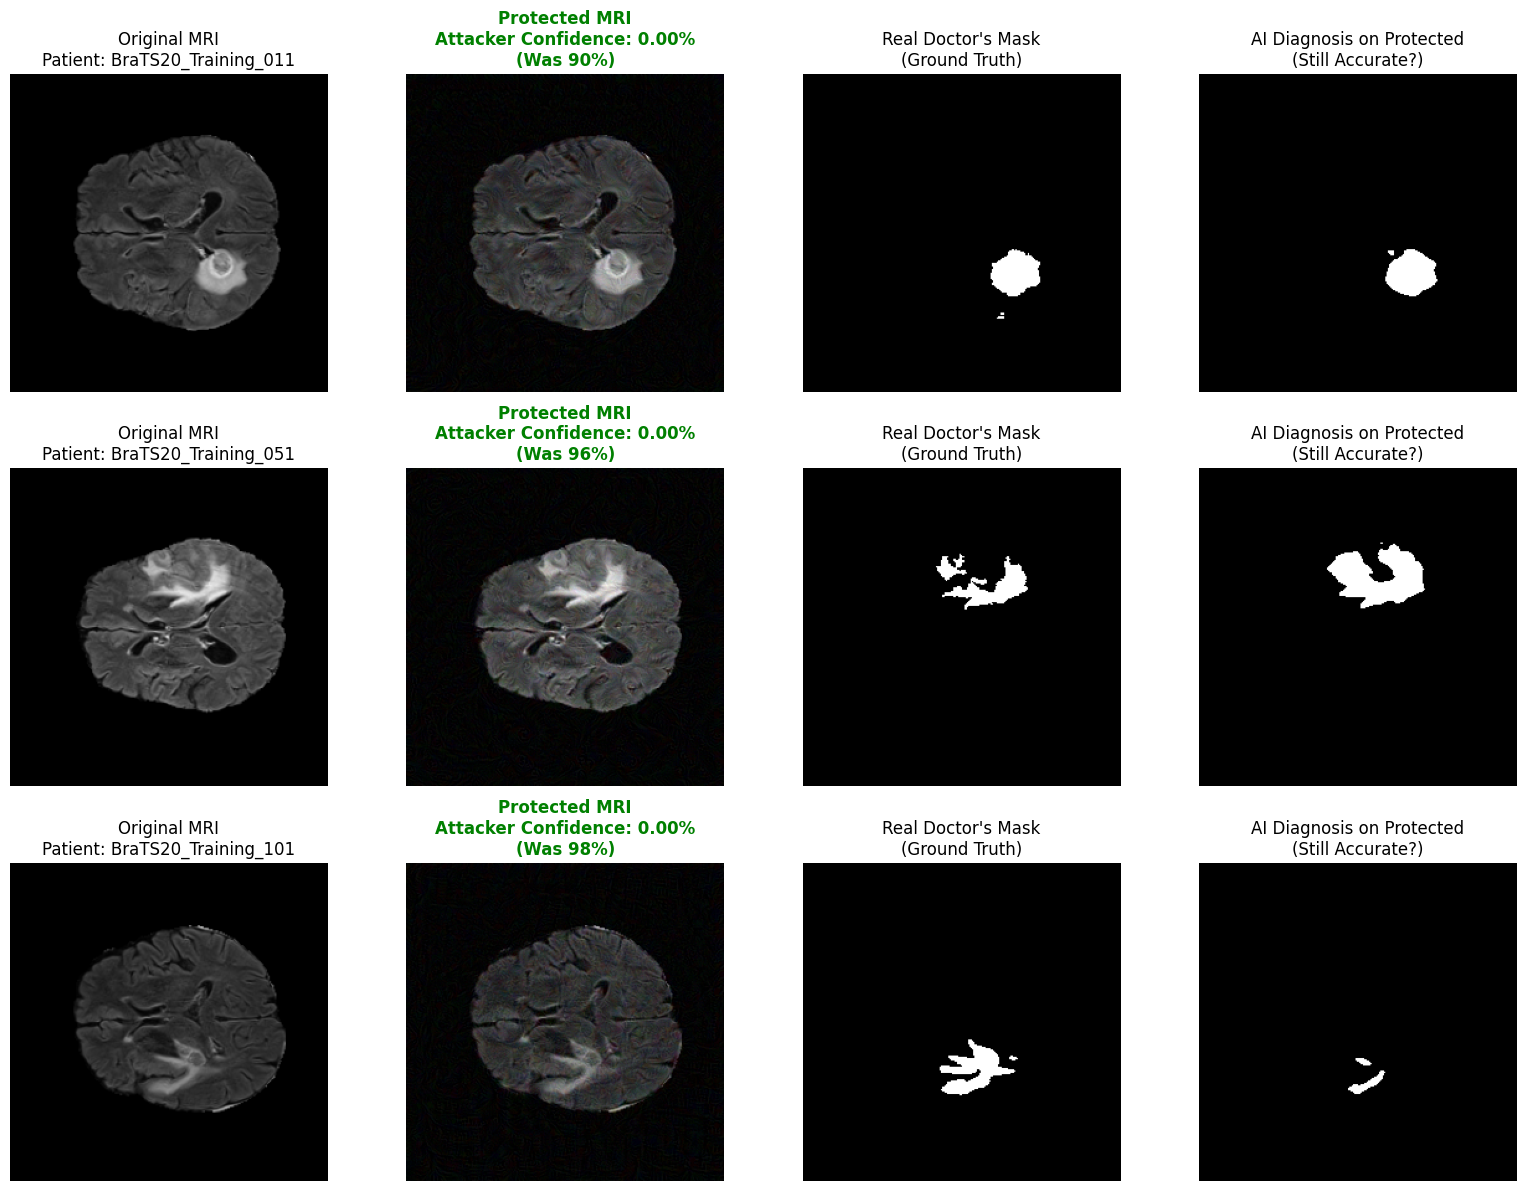

In [ ]:
import matplotlib.pyplot as plt
import torch
import numpy as np
import nibabel as nib
import cv2
import os

# --- HELPER: GET FULL DATA (Image + Mask + ID) ---
# We need to grab the mask manually since the Attacker Loader doesn't give it
def get_verification_sample(dataset, idx):
    # Get path from dataset
    p_dir = dataset.patient_dirs[idx]
    p_id = os.path.basename(p_dir)

    # Load Image (FLAIR)
    flair_path = os.path.join(p_dir, f"{p_id}_flair.nii")
    flair_vol = nib.load(flair_path).get_fdata()
    slice_idx = flair_vol.shape[2] // 2
    img = flair_vol[:, :, slice_idx]
    img = (img - np.min(img)) / (np.max(img) - np.min(img) + 1e-6)
    img = cv2.resize(img, (256, 256))
    img_tensor = torch.tensor(img, dtype=torch.float32).unsqueeze(0).repeat(3, 1, 1).unsqueeze(0) # Add batch dim

    # Load Mask (Ground Truth)
    seg_path = os.path.join(p_dir, f"{p_id}_seg.nii")
    seg_vol = nib.load(seg_path).get_fdata()
    mask = seg_vol[:, :, slice_idx]
    mask = np.where(mask > 0, 1.0, 0.0)
    mask = cv2.resize(mask, (256, 256), interpolation=cv2.INTER_NEAREST)

    # Label (ID)
    label = torch.tensor([dataset.class_to_idx[p_dir]])

    return img_tensor.to(DEVICE), mask, label.to(DEVICE), p_id

# --- RUN VERIFICATION ---
print("🛡️ RUNNING FINAL DEFENSE CHECK...")

# 1. Pick 3 random patients
indices = [10, 50, 100] # Random indices
samples = [get_verification_sample(attack_dataset, i) for i in indices]

plt.figure(figsize=(16, 12))

for i, (real_img, real_mask, label, p_id_str) in enumerate(samples):

    # A. Generate Privacy Noise (Defense)
    protected_img = generate_defense_noise(real_img, label, attacker, epsilon=0.05)

    # B. ATTACKER CHECK (Did it work?)
    # Original Guess
    orig_pred = attacker(real_img)
    orig_prob = torch.softmax(orig_pred, dim=1)[0, label].item() * 100

    # Protected Guess
    prot_pred = attacker(protected_img)
    prot_prob = torch.softmax(prot_pred, dim=1)[0, label].item() * 100
    prot_guess_idx = torch.argmax(prot_pred, dim=1).item()

    # C. DOCTOR CHECK (Utility)
    # AI Prediction on Protected Image
    ai_pred = doctor(protected_img)
    ai_mask = (torch.sigmoid(ai_pred) > 0.5).float().cpu().numpy()[0, 0]

    # --- VISUALIZATION ---
    # Col 1: Original Image
    plt.subplot(3, 4, i*4 + 1)
    plt.imshow(real_img[0].detach().cpu().permute(1, 2, 0))
    plt.title(f"Original MRI\nPatient: {p_id_str}")
    plt.axis('off')

    # Col 2: Protected Image (Attacker Result)
    plt.subplot(3, 4, i*4 + 2)
    plt.imshow(protected_img[0].detach().cpu().permute(1, 2, 0))
    color = "green" if prot_prob < 1.0 else "red"
    plt.title(f"Protected MRI\nAttacker Confidence: {prot_prob:.2f}%\n(Was {orig_prob:.0f}%)", color=color, fontweight='bold')
    plt.axis('off')

    # Col 3: Original Doctor's Mask (Ground Truth)
    plt.subplot(3, 4, i*4 + 3)
    plt.imshow(real_mask, cmap='gray')
    plt.title("Real Doctor's Mask\n(Ground Truth)")
    plt.axis('off')

    # Col 4: AI Prediction on Protected Image
    plt.subplot(3, 4, i*4 + 4)
    plt.imshow(ai_mask, cmap='gray')
    plt.title("AI Diagnosis on Protected\n(Still Accurate?)")
    plt.axis('off')

plt.tight_layout()
plt.show()